In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Basic use

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [2]:
# imports
import numpy as np 
import matplotlib.pyplot as plt 
import nangs
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.1', '1.5.0')

## Define your PDE

We provide the class `PDE` with the default functionality to solve the PDE. First, create a new class inheriting from the `PDE` class and overload the `computePDELoss` function to return one loss function for each PDE in your system. You must initialize this class with your inputs and outputs names. 

In [3]:
from nangs import PDE

class Adv1d(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        u = inputs[:,2]
        return {'pde': dpdt + u*dpdx}
    
pde = Adv1d(inputs=('x', 't', 'u'), outputs='p')

pde.inputs, pde.outputs

(('x', 't', 'u'), ('p',))

## Define your data

To solve the PDE we first need a set of points to evaluate it, we will use this points as the dataset for training de NN.

In [4]:
# define the mesh

x = np.linspace(0,1,20)
t = np.linspace(0,1,30)
u = np.linspace(-1,1,10)

The class `Mesh` will combine all the posible values on the previous arrays to build a mesh. You must pass the data as a dict, providing one (unique) name for each variable matching the names of the inputs defined in the PDE.

In [5]:
from nangs import Mesh

mesh = Mesh({'x': x, 't': t, 'u': u})
mesh.vars

('x', 't', 'u')

In order to train a NN we need a `Dataset`. A `Mesh` has in fact a `Dataset` that you can iterate over.

In [6]:
len(mesh.dataset)

6000

In [7]:
mesh.dataset[:3]

tensor([[ 0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000, -0.7778],
        [ 0.0000,  0.0000, -0.5556]])

You can also specify the device to cache the data

In [8]:
mesh = Mesh({'x': x, 't': t, 'u': u}, device=device)
mesh.dataset[:3]

tensor([[ 0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000, -0.7778],
        [ 0.0000,  0.0000, -0.5556]], device='cuda:0')

Finally, add the mesh to your PDE.

In [9]:
pde.set_mesh(mesh)

In [10]:
mesh.vars

('x', 't', 'u')

In [11]:
pde.inputs

('x', 't', 'u')

## Boundary Conditions

In order to find a non-trivial solution to our PDE we need to specify a set of boundary conditions. Nangs provide different classes for common boundary conditions.

In [12]:
# initial condition (t = 0)

t0 = np.array([0])
_x, _t, _u = np.meshgrid(x, t0, u)
p0 = np.sin(2*np.pi*(_x- _u*_t))
p0.shape

(1, 20, 10)

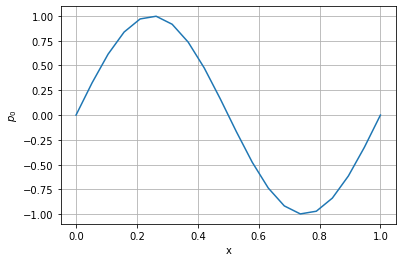

In [13]:
plt.plot(x, p0[0,:,0])
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

A boundary condition has its own `Mesh` and logic to compute values and gradients. In a `Dirichlet` boundary conditions we are fixing some values, so we need the inputs and also the target outputs (in this case, our initial condition). If you are including some free-parameters as NN inputs, make sure you specify an initial condition for each one of them (here we use the same for every value of $u$).

In [14]:
from nangs import Dirichlet

initial_condition = Dirichlet({'x': x, 't': t0, 'u': u}, {'p': p0.reshape(-1)}, device=device, name="initial")
initial_condition.vars

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


[('x', 't', 'u'), ('p',)]

In [15]:
initial_condition.dataset[:5]

(tensor([[ 0.0000,  0.0000, -1.0000],
         [ 0.0000,  0.0000, -0.7778],
         [ 0.0000,  0.0000, -0.5556],
         [ 0.0000,  0.0000, -0.3333],
         [ 0.0000,  0.0000, -0.1111]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

In [16]:
pde.add_boco(initial_condition)

We use a periodic boundary condition at $x=0$ and $x=1$. During training we will enforce this values to match.

In [17]:
# boundary conditions (peridic conditions at x = 0 and x = 1)

xb0 = np.array([0])
mb0 = np.meshgrid(xb0, t)
mb0 = np.stack(mb0, -1).reshape(-1, 2)
mb0.shape

(30, 2)

In [18]:
from nangs import Periodic

x1 = np.array([0.])
x2 = np.array([1.])
periodic = Periodic({'x': x1, 't': t, 'u': u}, {'x': x2, 't': t, 'u': u}, device=device)
periodic.vars

[('x', 't', 'u'), ('x', 't', 'u')]

In [19]:
periodic.dataset[:5]

(tensor([[ 0.0000,  0.0000, -1.0000],
         [ 0.0000,  0.0000, -0.7778],
         [ 0.0000,  0.0000, -0.5556],
         [ 0.0000,  0.0000, -0.3333],
         [ 0.0000,  0.0000, -0.1111]], device='cuda:0'),
 tensor([[ 1.0000,  0.0000, -1.0000],
         [ 1.0000,  0.0000, -0.7778],
         [ 1.0000,  0.0000, -0.5556],
         [ 1.0000,  0.0000, -0.3333],
         [ 1.0000,  0.0000, -0.1111]], device='cuda:0'))

In [20]:
pde.add_boco(periodic)

## Define your solution

We provide a basic `MLP` class to impement a Multilayer Perceptron as solution approxiamtion to the PDE, but you can always define you own NN (just be sure to match the number of inputs and outputs).

In [21]:
from nangs import MLP

mlp = MLP(inputs=len(pde.inputs), outputs=len(pde.outputs), layers=3, neurons=100)

mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (3): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [22]:
assert mlp(torch.randn(32, len(pde.inputs))).shape == torch.randn(32, len(pde.outputs)).shape

## Solve the PDE

To solve the PDE, you must first call de `compile` function to specify the NN, optimizer and optionally the loss function (we use MSE by default) or a learning rate scheduler.

In [23]:
EPOCHS = 40

optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp.to(device), optimizer, scheduler)

To solve the PDE, call the `solve` function with a number of epochs and batch size for the optimization process. It returns a hitory with all the tracked metrics.

In [24]:
BATCH_SIZE = 256

hist = pde.solve(EPOCHS, BATCH_SIZE)

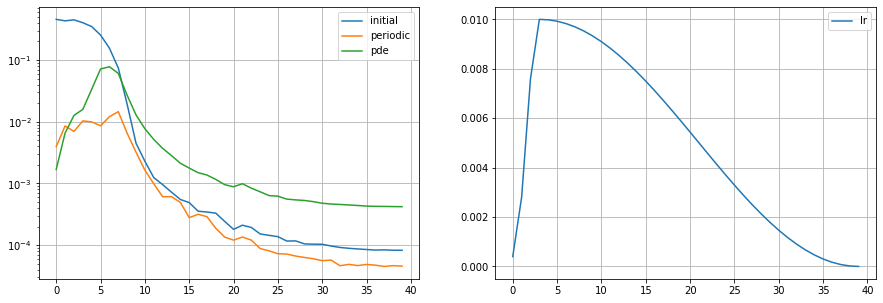

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for name, vale in hist.items():
    if name is not 'lr':
        ax1.plot(hist[name], label=name)
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
ax2.plot(hist['lr'], label='lr')
ax2.grid(True)
ax2.legend()
plt.show()

## Evaluate your solution

Finally, you can evaluate your solution

In [26]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, u, t, p):
    ax.clear()
    pe = np.sin(2.*np.pi*(x-u*t[i]))
    ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} (L2 = {l2:.5f})")
    return ax

In [27]:
#t = np.linspace(0,1,10)
U = -0.5

x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
u = np.array([U])
eval_mesh = Mesh({'x': x, 't': t, 'u': u}, device=device)

p = pde.eval(eval_mesh)
p = p.cpu().numpy().reshape(len(t), -1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, U, t, p), interval=300)
plt.close()

In [28]:
anim